## Revisiting our nonlinear fitting example with MCMC sampling

We return to our original model with 5 parameters, for which it would be impractical to evaluate the posterior distribution over a grid of parameters. 

$$
y(x) = b_1 \exp\left(-b_2 x\right) + \frac{b_3}{b_5\sqrt{2\pi}} \exp\left(-\tfrac12\frac{(x-b_4)^2}{b_5^2}\right)
$$

(the sum of a decaying exponential background, and a Gaussian peak). 


We first load some standard packages, including `emcee` for MCMC sampling and `corner` for visualisation of the posterior.


In [1]:
import numpy as np
import os, sys
from numpy import exp, pi, sqrt

from numpy import linspace

import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt

import scipy.optimize as optimization
from lmfit import minimize, Parameters, report_fit
from scipy.optimize import leastsq
import emcee #conda install -c conda-forge emcee



We then proceed as in the previous example, loading the dataset, and defining the log-likelihood, the log-prior, and the log-posterior functions.

In [2]:
data = pd.read_csv("exppeak.txt", header=0, delim_whitespace=True)
data


,x,y,sigma
0,0.000,1.17747,0.0357
1,0.526,0.64436,0.0272
2,1.053,0.53100,0.0353
3,1.579,0.52761,0.0323
4,2.105,0.64534,0.0313
5,2.632,0.80235,0.0419
6,3.158,0.82748,0.0334
7,3.684,0.74864,0.0265
8,4.211,0.64265,0.0364
9,4.737,0.48122,0.0375


In [3]:

def model_peak(x, b1, b2, b3, b4, b5):
    return b1*exp(-b2*x) + b3/(sqrt(2*np.pi)*b5)*exp(-0.5*(x-b4)**2 / b5**2)

def log_likelihood(theta, x, y, yerr):
    b1, b2, b3, b4, b5 = theta
    model = model_peak(x, b1, b2, b3, b4, b5)
    logLhood0=np.size(y)/2*np.log(2*np.pi)+np.sum(np.log(yerr))
    chi2=np.sum(((y - model)/yerr)**2)
    return -chi2/2-logLhood0

def log_prior(theta):
    b1, b2, b3, b4, b5 = theta
    if 0.5 < b1 < 2 and 1. < b2 < 2 and 1 < b3 < 5.0 and 1.0 < b4 < 5 and 1. < b5 < 2.0:
        return 0.0
    return -np.inf

def log_posterior(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


We first seek the optimum parameters by minimising the (negative) log-likelihood, and visualise the fit

Maximum likelihood estimates:
b1 = 1.083
b2 = 1.594
b3 = 3.110
b4 = 3.207
b5 = 1.552


Text(0, 0.5, 'y')

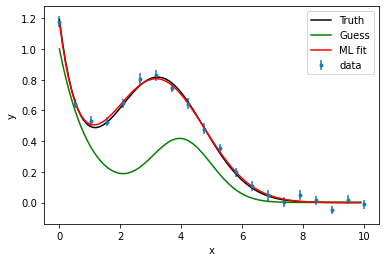

In [4]:
nll = lambda *args: -log_likelihood(*args)
initial = [1, 1, 1, 4,  1]
soln = optimization.minimize(nll, initial, args=(data.x, data.y, data.sigma))
b1, b2, b3, b4, b5 = soln.x

print("Maximum likelihood estimates:")
print("b1 = {0:.3f}".format(b1))
print("b2 = {0:.3f}".format(b2))
print("b3 = {0:.3f}".format(b3))
print("b4 = {0:.3f}".format(b4))
print("b5 = {0:.3f}".format(b5))

xx = np.arange(0,10,0.1)
p_truth = [1.12, 1.52, 3, 3.26,  1.48]
truth = model_peak(xx, *p_truth)
guess = model_peak(xx, *initial)
fit_ML = model_peak(xx, b1, b2, b3, b4, b5)
pyplot.errorbar(data.loc[:,'x'], data.loc[:,'y'], yerr=data.loc[:,'sigma'], fmt='.', label='data')
pyplot.plot(xx, truth, 'k-', label='Truth')
pyplot.plot(xx, guess, 'g', label='Guess')
pyplot.plot(xx, fit_ML, 'r', label='ML fit')
pyplot.legend(loc='best')
pyplot.xlabel("x")
pyplot.ylabel("y")


### Sampling the posterior density

MCMC allows us to sample the posterior distribution and thus gain some understanding of its shape around the optimum parameter values. This solnling is done via _Markov chains_, which we can think about as random walks in the parameter space. To get a more reliable result, several "walkers" are run in parallel, each with a different starting point. Since we are most interested in the posterior's shape around the maximum, we choose random starting points close to this maximum, for example:

In [5]:
soln.x + 1e-4 * np.random.randn(12, 5)

array([[1.0823876 , 1.59386719, 3.11010714, 3.20660868, 1.55170751],
       [1.08261343, 1.5937265 , 3.1104251 , 3.20642335, 1.55165622],
       [1.08243095, 1.59384169, 3.11023314, 3.20665387, 1.55176051],
       [1.08233536, 1.59366526, 3.11027403, 3.20659327, 1.55178218],
       [1.0825858 , 1.59386002, 3.11035792, 3.20669072, 1.5516467 ],
       [1.08256639, 1.59372896, 3.11014732, 3.20666428, 1.5518133 ],
       [1.08251245, 1.59380216, 3.11039025, 3.2065474 , 1.55184496],
       [1.08251992, 1.59383695, 3.11015795, 3.20655538, 1.55173872],
       [1.08258598, 1.59383277, 3.11021095, 3.20657282, 1.55184531],
       [1.08255997, 1.59371991, 3.11025562, 3.20642684, 1.55174756],
       [1.08259651, 1.5938106 , 3.11027874, 3.206563  , 1.55183963],
       [1.08244543, 1.5937451 , 3.11035527, 3.20666038, 1.55176184]])

We now run the sampler with 32 walkers and a maximum number of 5000 steps, which takes a bit of time. 

In [6]:
import emcee

pos = soln.x + 1e-3 * np.random.randn(32, 5)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(data.x, data.y, data.sigma)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [02:46<00:00, 30.03it/s]


We can plot the sampled values for each parameter as follows:

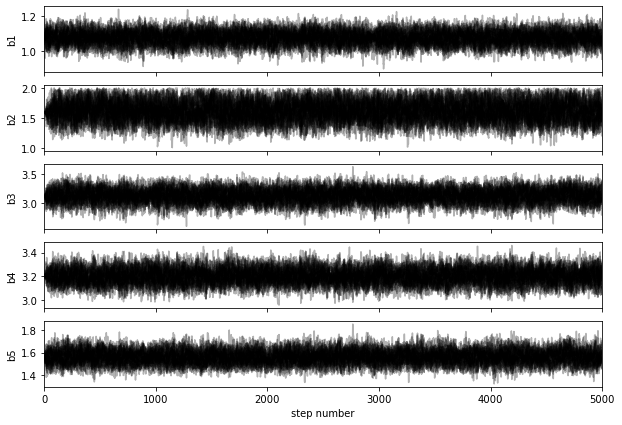

In [7]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["b1", "b2", "b3", "b4", "b5"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    
axes[-1].set_xlabel("step number");

The initial steps taken by the walkers are usually discarded (known as _burn-in_ period), as the walkers are not necessarily exploring a representative region of the posterior distribution. A common way to decide how many iterations should be discarded is to evaluate the autocorrelation time of the walks. 

In [10]:
tau = sampler.get_autocorr_time()
print(tau)

[58.08490385 57.9926111  54.5014361  56.34124705 52.3393036 ]


As a rule of thumb, we might discard the initial steps up to about twice this autocorrelation time. We also _thin_ (sub-sample) the chains by roughly half this amount, to reduce the correlation between adjacent values:

In [17]:
flat_samples = sampler.get_chain(discard=100, thin=20, flat=True)
print(flat_samples.shape)

(7840, 5)


With these sampled values, we can now estimate various quantities from the posterior distribution. For instance, the best parameter values are near the maximum of the posterior distribution, and we can access them via:

In [18]:
# Get the index of the most probable parameter set
max_ind = np.argmax(sampler.flatlnprobability)

b1_MCMC, b2_MCMC, b3_MCMC, b4_MCMC, b5_MCMC = sampler.flatchain[max_ind,:]

print("""
Most probable parameter values from MCMC sampling:
b1:  {0:.3f}
b2: {1:.3f}
b3:  {2:.3f}
b4: {3:.3f}
b5: {4:.3f}
""".format(b1_MCMC, b2_MCMC, b3_MCMC, b4_MCMC, b5_MCMC))


Most probable parameter values from MCMC sampling:
b1:  1.083
b2: 1.594
b3:  3.110
b4: 3.206
b5: 1.552



Note, however, that the real purpose of MCMC sampling is _not_ to find the optimum values (for this, it is better to use a minimiser), but rather to inform us on the shape of the posterior distribution. We can for instance compute the standard deviation to summarise the uncertainty on the fitted parameters:

In [19]:
# Compute error bars by taking standard deviation
b1_err, b2_err, b3_err, b4_err, b5_err = sampler.flatchain.std(axis=0)

print('Error bars:\n', b1_err, b2_err, b3_err, b4_err, b5_err)

Error bars:
 0.0386747708259245 0.16209889231109387 0.11549947477834956 0.06291385617929797 0.0597530583944446


in reasonable agreement with the estimates from the Hessian matrix (which supposes that the posterior density has gaussian shape):

In [22]:
print('Error bars from Hessian:\n', np.sqrt(np.diag(soln.hess_inv)))

Error bars from Hessian:
 [0.03815517 0.17042324 0.11786717 0.06522477 0.05940693]


Finally, we can summarise the posterior distribution with a corner plot, illustrating the marginalised parameter distributions and all pairwise correlations:

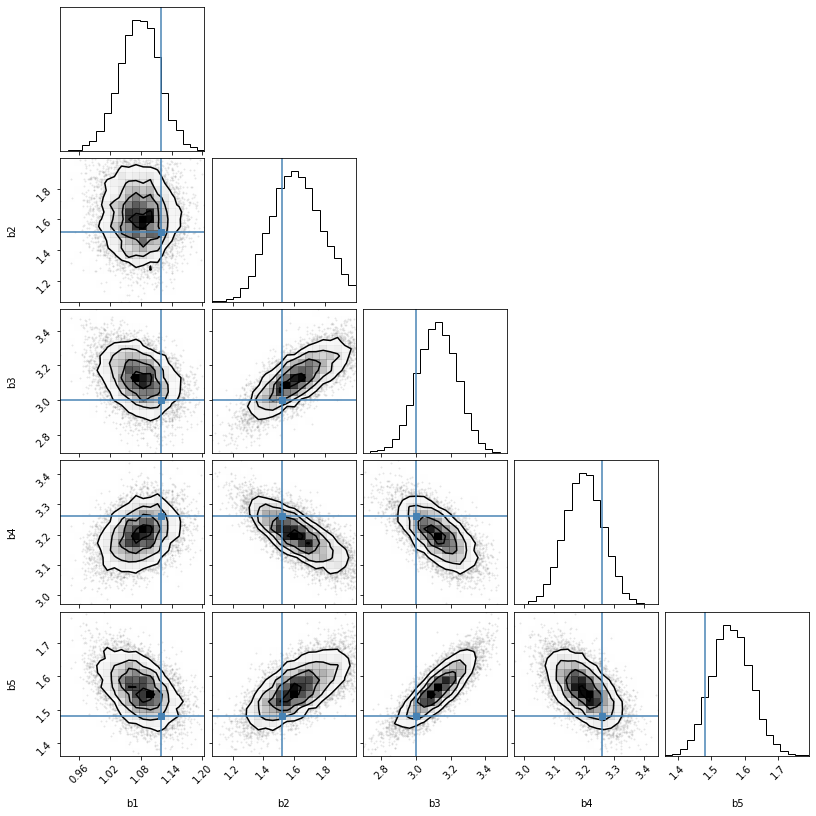

In [20]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=  p_truth
);

Note how the "true" values of the parameters are close, but not necessarily exactly on top of the posterior maximum. 

_Download this page [as a Jupyter notebook](https://github.com/vuw-scps/python-physics/raw/master/notebooks/phys345/fitting_04_MCMC.ipynb) or as a [standalone Python script](https://github.com/vuw-scps/python-physics/raw/master/scripts/phys345/fitting_04_MCMC.py)._